In [1]:
import torch
import numpy as np
import cv2
import os
import random as rand
import torchvision
import pandas as pd
from tqdm import tqdm
from torch import nn, Tensor
from torch.nn import utils
import matplotlib.pyplot as plt
from typing import Optional
from torch.nn import functional as F
from torchvision.transforms import v2 as T
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from math import ceil

In [2]:
class CIFAR(Dataset):
    def __init__(self, path="/scratch/s25090/archive/cifar-10/train", dataset:Optional[list]=None):
        super().__init__()
        self.path = path
        self.files = os.listdir(self.path) if dataset is None else dataset
        self.T = T.Compose([
           T.ToImage(), 
           T.ToDtype(torch.float32, scale=True),
           T.Resize((32, 32)),
           T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

    def __len__(self,):
        return len(self.files)
    
    def __getitem__(self, idx):
        file = self.files[idx]
        img_path = os.path.join(self.path, file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.T(img)
        return img

In [3]:
class SNDiscriminator(nn.Module):
    def __init__(self, channels_img=3, features_d=64):
        super(SNDiscriminator, self).__init__()
        
        # Helper to create a spectral normalized block
        def sn_block(in_channels, out_channels, kernel_size, stride, padding):
            return nn.Sequential(
                # WRAP THE CONV LAYER WITH SPECTRAL_NORM
                utils.spectral_norm(
                    nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
                ),
                nn.LeakyReLU(0.2), 
                # Note: SN-GANs usually remove Batch Norm in the Discriminator entirely
            )

        self.disc = nn.Sequential(
            # Input: N x 3 x 32 x 32
            sn_block(channels_img, features_d, 3, 1, 1),
            
            # Downsampling blocks
            sn_block(features_d, features_d * 2, 4, 2, 1),
            sn_block(features_d * 2, features_d * 4, 4, 2, 1),
            sn_block(features_d * 4, features_d * 8, 4, 2, 1),
            
            # Final output layer (Single scalar score)
            # We also apply Spectral Norm to the final layer
            utils.spectral_norm(nn.Conv2d(features_d * 8, 1, 4, 1, 0)),
        )

    def forward(self, x):
        return self.disc(x).view(-1)

class ResGenBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv_block = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        )
        
        self.shortcut = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False)
        )

    def forward(self, x):
        return self.conv_block(x) + self.shortcut(x)

In [4]:
class ResNetGenerator(nn.Module):
    def __init__(self, z_dim=100, features_g=256, channels_img=3):
        super().__init__()
        self.linear = nn.Linear(z_dim, 4 * 4 * features_g)
        self.features_g = features_g
        
        self.net = nn.Sequential(
            ResGenBlock(features_g, features_g),
            ResGenBlock(features_g, features_g),  
            ResGenBlock(features_g, features_g),  
            
            nn.BatchNorm2d(features_g),
            nn.ReLU(inplace=True),
            nn.Conv2d(features_g, channels_img, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.linear(z)
        x = x.view(-1, self.features_g, 4, 4)
        return self.net(x)

class SNDiscriminator(nn.Module):
    def __init__(self, channels_img=3, features_d=64):
        super(SNDiscriminator, self).__init__()
        
        def sn_block(in_channels, out_channels, kernel_size, stride, padding):
            return nn.Sequential(
                utils.spectral_norm(
                    nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
                ),
                nn.LeakyReLU(0.2, inplace=True), 
            )

        self.disc = nn.Sequential(
            sn_block(channels_img, features_d, 3, 1, 1),        
            sn_block(features_d, features_d * 2, 4, 2, 1),      
            sn_block(features_d * 2, features_d * 4, 4, 2, 1),
            sn_block(features_d * 4, features_d * 8, 4, 2, 1),
            utils.spectral_norm(nn.Conv2d(features_d * 8, 1, 4, 1, 0)),
        )

    def forward(self, x):
        return self.disc(x).view(-1)
    
class SGANModel(nn.Module):
    def __init__(self, z_dim=100, channels_img=3, features_g=256, features_d=64):
        super().__init__()
        self.generator = ResNetGenerator(z_dim, features_g, channels_img)
        self.discriminator = SNDiscriminator(channels_img, features_d)
        self.z_dim = z_dim

    def forward(self, z):
        return self.generator(z)

    def compute_discriminator_loss(self, real_imgs, z):
        with torch.no_grad():
            fake_imgs = self.generator(z).detach()

        real_logits = self.discriminator(real_imgs)
        fake_logits = self.discriminator(fake_imgs)
        
        loss_real = torch.mean(F.relu(1.0 - real_logits))
        loss_fake = torch.mean(F.relu(1.0 + fake_logits))
        
        d_loss = loss_real + loss_fake
        return d_loss

    def compute_generator_loss(self, z):
        fake_imgs = self.generator(z)
        fake_logits = self.discriminator(fake_imgs)
        
        g_loss = -torch.mean(fake_logits)
        
        return g_loss, fake_imgs

Epoch 1/200: 100%|██████████| 782/782 [01:18<00:00,  9.96it/s, d_loss=0.979, g_loss=2.59]   


Generator Loss: 1.0748 | Discriminator Loss: 1.2634


Epoch 2/200: 100%|██████████| 782/782 [01:12<00:00, 10.74it/s, d_loss=1.42, g_loss=0.0845] 


Generator Loss: 0.6299 | Discriminator Loss: 1.6274


Epoch 3/200: 100%|██████████| 782/782 [00:28<00:00, 27.72it/s, d_loss=1.56, g_loss=-0.00667]


Generator Loss: 0.4790 | Discriminator Loss: 1.7555


Epoch 4/200: 100%|██████████| 782/782 [00:28<00:00, 27.64it/s, d_loss=1.55, g_loss=1.22]   


Generator Loss: 0.4116 | Discriminator Loss: 1.8188


Epoch 5/200: 100%|██████████| 782/782 [00:28<00:00, 27.52it/s, d_loss=1.66, g_loss=-0.447]   


Generator Loss: 0.3653 | Discriminator Loss: 1.8300


Epoch 6/200: 100%|██████████| 782/782 [00:27<00:00, 28.93it/s, d_loss=1.48, g_loss=0.383]   


Generator Loss: 0.3336 | Discriminator Loss: 1.8565


Epoch 7/200: 100%|██████████| 782/782 [00:26<00:00, 29.09it/s, d_loss=1.73, g_loss=-0.0504] 


Generator Loss: 0.3518 | Discriminator Loss: 1.8688


Epoch 8/200: 100%|██████████| 782/782 [00:26<00:00, 29.90it/s, d_loss=1.52, g_loss=0.267]   


Generator Loss: 0.2543 | Discriminator Loss: 1.8752


Epoch 9/200: 100%|██████████| 782/782 [00:26<00:00, 29.42it/s, d_loss=1.62, g_loss=0.322]  


Generator Loss: 0.2492 | Discriminator Loss: 1.8682


Epoch 10/200: 100%|██████████| 782/782 [00:27<00:00, 28.47it/s, d_loss=1.67, g_loss=0.631]  


Generator Loss: 0.3539 | Discriminator Loss: 1.8794


Epoch 11/200: 100%|██████████| 782/782 [00:24<00:00, 32.14it/s, d_loss=1.89, g_loss=0.282]   


Generator Loss: 0.3348 | Discriminator Loss: 1.8784


Epoch 12/200: 100%|██████████| 782/782 [00:25<00:00, 30.74it/s, d_loss=1.69, g_loss=-0.341] 


Generator Loss: 0.2463 | Discriminator Loss: 1.8883


Epoch 13/200: 100%|██████████| 782/782 [00:26<00:00, 29.31it/s, d_loss=1.62, g_loss=0.201]  


Generator Loss: 0.2514 | Discriminator Loss: 1.8933


Epoch 14/200: 100%|██████████| 782/782 [00:26<00:00, 29.06it/s, d_loss=1.78, g_loss=0.113]   


Generator Loss: 0.2551 | Discriminator Loss: 1.8999


Epoch 15/200: 100%|██████████| 782/782 [00:27<00:00, 28.87it/s, d_loss=1.72, g_loss=0.214]   


Generator Loss: 0.2675 | Discriminator Loss: 1.8957


Epoch 16/200: 100%|██████████| 782/782 [00:26<00:00, 29.56it/s, d_loss=2.07, g_loss=0.0762] 


Generator Loss: 0.2857 | Discriminator Loss: 1.8951


Epoch 17/200: 100%|██████████| 782/782 [00:26<00:00, 29.27it/s, d_loss=1.76, g_loss=0.118]   


Generator Loss: 0.2771 | Discriminator Loss: 1.9003


Epoch 18/200: 100%|██████████| 782/782 [00:26<00:00, 29.26it/s, d_loss=1.75, g_loss=-0.0395]


Generator Loss: 0.2662 | Discriminator Loss: 1.8934


Epoch 19/200: 100%|██████████| 782/782 [00:26<00:00, 29.13it/s, d_loss=1.87, g_loss=0.0665]  


Generator Loss: 0.2071 | Discriminator Loss: 1.8956


Epoch 20/200: 100%|██████████| 782/782 [00:22<00:00, 34.30it/s, d_loss=1.78, g_loss=-0.268]  


Generator Loss: 0.2213 | Discriminator Loss: 1.8932


Epoch 21/200: 100%|██████████| 782/782 [00:24<00:00, 31.55it/s, d_loss=1.76, g_loss=0.457]  


Generator Loss: 0.2381 | Discriminator Loss: 1.8969


Epoch 22/200: 100%|██████████| 782/782 [00:26<00:00, 29.10it/s, d_loss=1.66, g_loss=0.3]     


Generator Loss: 0.2243 | Discriminator Loss: 1.8908


Epoch 23/200: 100%|██████████| 782/782 [00:27<00:00, 28.72it/s, d_loss=1.74, g_loss=0.602]   


Generator Loss: 0.2443 | Discriminator Loss: 1.8859


Epoch 24/200: 100%|██████████| 782/782 [00:27<00:00, 27.93it/s, d_loss=1.79, g_loss=0.448]   


Generator Loss: 0.2437 | Discriminator Loss: 1.8882


Epoch 25/200: 100%|██████████| 782/782 [00:26<00:00, 29.51it/s, d_loss=1.61, g_loss=-0.289]  


Generator Loss: 0.2739 | Discriminator Loss: 1.8810


Epoch 26/200: 100%|██████████| 782/782 [00:27<00:00, 28.95it/s, d_loss=1.76, g_loss=0.464]   


Generator Loss: 0.1936 | Discriminator Loss: 1.8851


Epoch 27/200: 100%|██████████| 782/782 [00:26<00:00, 29.34it/s, d_loss=1.86, g_loss=-0.161]  


Generator Loss: 0.2245 | Discriminator Loss: 1.8851


Epoch 28/200: 100%|██████████| 782/782 [00:26<00:00, 29.63it/s, d_loss=1.86, g_loss=0.392]    


Generator Loss: 0.2313 | Discriminator Loss: 1.8837


Epoch 29/200: 100%|██████████| 782/782 [00:22<00:00, 35.13it/s, d_loss=1.65, g_loss=0.0836] 


Generator Loss: 0.2310 | Discriminator Loss: 1.8820


Epoch 30/200: 100%|██████████| 782/782 [00:25<00:00, 30.20it/s, d_loss=1.7, g_loss=0.778]   


Generator Loss: 0.2393 | Discriminator Loss: 1.8804


Epoch 31/200: 100%|██████████| 782/782 [00:26<00:00, 28.98it/s, d_loss=1.87, g_loss=0.262]   


Generator Loss: 0.2337 | Discriminator Loss: 1.8824


Epoch 32/200: 100%|██████████| 782/782 [00:26<00:00, 28.99it/s, d_loss=1.78, g_loss=0.132]  


Generator Loss: 0.2753 | Discriminator Loss: 1.8748


Epoch 33/200: 100%|██████████| 782/782 [00:26<00:00, 29.17it/s, d_loss=1.82, g_loss=0.521]   


Generator Loss: 0.2586 | Discriminator Loss: 1.8797


Epoch 34/200: 100%|██████████| 782/782 [00:26<00:00, 29.42it/s, d_loss=1.83, g_loss=0.584]   


Generator Loss: 0.2262 | Discriminator Loss: 1.8756


Epoch 35/200: 100%|██████████| 782/782 [00:26<00:00, 29.03it/s, d_loss=1.75, g_loss=0.202]  


Generator Loss: 0.2384 | Discriminator Loss: 1.8772


Epoch 36/200: 100%|██████████| 782/782 [00:26<00:00, 29.36it/s, d_loss=1.85, g_loss=0.116]    


Generator Loss: 0.2102 | Discriminator Loss: 1.8758


Epoch 37/200: 100%|██████████| 782/782 [00:25<00:00, 30.24it/s, d_loss=1.88, g_loss=0.411]  


Generator Loss: 0.2308 | Discriminator Loss: 1.8714


Epoch 38/200: 100%|██████████| 782/782 [00:23<00:00, 33.25it/s, d_loss=1.79, g_loss=0.443]   


Generator Loss: 0.2571 | Discriminator Loss: 1.8719


Epoch 39/200: 100%|██████████| 782/782 [00:26<00:00, 29.48it/s, d_loss=1.76, g_loss=0.161]  


Generator Loss: 0.2518 | Discriminator Loss: 1.8707


Epoch 40/200: 100%|██████████| 782/782 [00:26<00:00, 29.25it/s, d_loss=1.93, g_loss=-0.0145]


Generator Loss: 0.2337 | Discriminator Loss: 1.8680


Epoch 41/200: 100%|██████████| 782/782 [00:27<00:00, 28.66it/s, d_loss=1.74, g_loss=0.0209] 


Generator Loss: 0.2104 | Discriminator Loss: 1.8674


Epoch 42/200: 100%|██████████| 782/782 [00:26<00:00, 28.98it/s, d_loss=1.81, g_loss=0.0178]  


Generator Loss: 0.2265 | Discriminator Loss: 1.8645


Epoch 43/200: 100%|██████████| 782/782 [00:27<00:00, 28.53it/s, d_loss=1.84, g_loss=0.271]  


Generator Loss: 0.2397 | Discriminator Loss: 1.8668


Epoch 44/200: 100%|██████████| 782/782 [00:27<00:00, 28.85it/s, d_loss=1.94, g_loss=0.341]   


Generator Loss: 0.2102 | Discriminator Loss: 1.8638


Epoch 45/200: 100%|██████████| 782/782 [00:27<00:00, 28.72it/s, d_loss=1.72, g_loss=0.689]   


Generator Loss: 0.2484 | Discriminator Loss: 1.8580


Epoch 46/200: 100%|██████████| 782/782 [00:24<00:00, 32.35it/s, d_loss=1.71, g_loss=0.247]   


Generator Loss: 0.2457 | Discriminator Loss: 1.8607


Epoch 47/200: 100%|██████████| 782/782 [00:59<00:00, 13.06it/s, d_loss=1.69, g_loss=0.161]   


Generator Loss: 0.2330 | Discriminator Loss: 1.8551


Epoch 48/200: 100%|██████████| 782/782 [00:36<00:00, 21.20it/s, d_loss=1.98, g_loss=0.461]   


Generator Loss: 0.2459 | Discriminator Loss: 1.8540


Epoch 49/200: 100%|██████████| 782/782 [00:26<00:00, 29.38it/s, d_loss=1.8, g_loss=0.0795]   


Generator Loss: 0.2449 | Discriminator Loss: 1.8513


Epoch 50/200: 100%|██████████| 782/782 [00:26<00:00, 29.73it/s, d_loss=1.86, g_loss=0.2]      


Generator Loss: 0.2339 | Discriminator Loss: 1.8496


Epoch 51/200: 100%|██████████| 782/782 [00:27<00:00, 28.96it/s, d_loss=1.81, g_loss=0.237]    


Generator Loss: 0.2347 | Discriminator Loss: 1.8496


Epoch 52/200: 100%|██████████| 782/782 [00:26<00:00, 29.50it/s, d_loss=1.83, g_loss=-0.0847]


Generator Loss: 0.2409 | Discriminator Loss: 1.8492


Epoch 53/200: 100%|██████████| 782/782 [00:24<00:00, 31.39it/s, d_loss=1.72, g_loss=0.439]   


Generator Loss: 0.2489 | Discriminator Loss: 1.8427


Epoch 54/200: 100%|██████████| 782/782 [00:24<00:00, 32.57it/s, d_loss=1.94, g_loss=0.495]  


Generator Loss: 0.2555 | Discriminator Loss: 1.8426


Epoch 55/200: 100%|██████████| 782/782 [00:26<00:00, 29.37it/s, d_loss=1.71, g_loss=0.229]   


Generator Loss: 0.2307 | Discriminator Loss: 1.8408


Epoch 56/200: 100%|██████████| 782/782 [00:27<00:00, 28.51it/s, d_loss=1.72, g_loss=0.285]  


Generator Loss: 0.2151 | Discriminator Loss: 1.8378


Epoch 57/200: 100%|██████████| 782/782 [00:26<00:00, 29.18it/s, d_loss=1.7, g_loss=0.064]    


Generator Loss: 0.2603 | Discriminator Loss: 1.8364


Epoch 58/200: 100%|██████████| 782/782 [00:26<00:00, 29.42it/s, d_loss=1.78, g_loss=0.218]  


Generator Loss: 0.2557 | Discriminator Loss: 1.8339


Epoch 59/200: 100%|██████████| 782/782 [00:26<00:00, 29.77it/s, d_loss=1.74, g_loss=0.382]   


Generator Loss: 0.2773 | Discriminator Loss: 1.8368


Epoch 60/200: 100%|██████████| 782/782 [00:27<00:00, 28.67it/s, d_loss=1.82, g_loss=0.346]   


Generator Loss: 0.2683 | Discriminator Loss: 1.8308


Epoch 61/200: 100%|██████████| 782/782 [00:26<00:00, 29.35it/s, d_loss=1.81, g_loss=-0.403]  


Generator Loss: 0.2418 | Discriminator Loss: 1.8327


Epoch 62/200: 100%|██████████| 782/782 [00:24<00:00, 32.36it/s, d_loss=1.73, g_loss=0.0217]  


Generator Loss: 0.2297 | Discriminator Loss: 1.8261


Epoch 63/200: 100%|██████████| 782/782 [00:24<00:00, 32.13it/s, d_loss=1.68, g_loss=0.0922]  


Generator Loss: 0.2371 | Discriminator Loss: 1.8287


Epoch 64/200: 100%|██████████| 782/782 [00:27<00:00, 28.30it/s, d_loss=1.74, g_loss=0.339]  


Generator Loss: 0.2466 | Discriminator Loss: 1.8227


Epoch 65/200: 100%|██████████| 782/782 [00:31<00:00, 24.91it/s, d_loss=1.73, g_loss=-0.189] 


Generator Loss: 0.2828 | Discriminator Loss: 1.8217


Epoch 66/200: 100%|██████████| 782/782 [00:31<00:00, 25.05it/s, d_loss=1.64, g_loss=-0.0159] 


Generator Loss: 0.2358 | Discriminator Loss: 1.8206


Epoch 67/200: 100%|██████████| 782/782 [00:32<00:00, 24.19it/s, d_loss=1.72, g_loss=-0.0473]


Generator Loss: 0.2741 | Discriminator Loss: 1.8187


Epoch 68/200: 100%|██████████| 782/782 [00:34<00:00, 22.76it/s, d_loss=1.64, g_loss=-0.185]  


Generator Loss: 0.2683 | Discriminator Loss: 1.8167


Epoch 69/200: 100%|██████████| 782/782 [00:36<00:00, 21.64it/s, d_loss=1.84, g_loss=0.295]   


Generator Loss: 0.2499 | Discriminator Loss: 1.8184


Epoch 70/200: 100%|██████████| 782/782 [00:35<00:00, 21.82it/s, d_loss=1.59, g_loss=0.469]   


Generator Loss: 0.2511 | Discriminator Loss: 1.8129


Epoch 71/200: 100%|██████████| 782/782 [00:38<00:00, 20.38it/s, d_loss=1.73, g_loss=0.232]   


Generator Loss: 0.2465 | Discriminator Loss: 1.8183


Epoch 72/200: 100%|██████████| 782/782 [00:37<00:00, 20.83it/s, d_loss=1.67, g_loss=0.11]     


Generator Loss: 0.2634 | Discriminator Loss: 1.8122


Epoch 73/200: 100%|██████████| 782/782 [00:36<00:00, 21.49it/s, d_loss=1.79, g_loss=0.0804] 


Generator Loss: 0.2993 | Discriminator Loss: 1.8067


Epoch 74/200: 100%|██████████| 782/782 [00:35<00:00, 21.90it/s, d_loss=1.82, g_loss=0.306]  


Generator Loss: 0.2626 | Discriminator Loss: 1.8049


Epoch 75/200: 100%|██████████| 782/782 [00:37<00:00, 21.13it/s, d_loss=1.88, g_loss=0.15]    


Generator Loss: 0.2696 | Discriminator Loss: 1.8009


Epoch 76/200: 100%|██████████| 782/782 [00:37<00:00, 21.00it/s, d_loss=1.85, g_loss=0.305]  


Generator Loss: 0.2880 | Discriminator Loss: 1.8052


Epoch 77/200: 100%|██████████| 782/782 [00:37<00:00, 21.12it/s, d_loss=1.75, g_loss=0.411]   


Generator Loss: 0.2422 | Discriminator Loss: 1.7983


Epoch 78/200: 100%|██████████| 782/782 [00:31<00:00, 24.83it/s, d_loss=1.69, g_loss=-0.208]  


Generator Loss: 0.2608 | Discriminator Loss: 1.7954


Epoch 79/200: 100%|██████████| 782/782 [00:28<00:00, 27.61it/s, d_loss=1.67, g_loss=0.442]  


Generator Loss: 0.2651 | Discriminator Loss: 1.7999


Epoch 80/200: 100%|██████████| 782/782 [00:29<00:00, 26.66it/s, d_loss=1.7, g_loss=-0.199]    


Generator Loss: 0.2780 | Discriminator Loss: 1.7937


Epoch 81/200: 100%|██████████| 782/782 [00:28<00:00, 27.21it/s, d_loss=1.73, g_loss=0.235]   


Generator Loss: 0.2941 | Discriminator Loss: 1.7901


Epoch 82/200: 100%|██████████| 782/782 [00:27<00:00, 28.11it/s, d_loss=1.61, g_loss=0.0537] 


Generator Loss: 0.2799 | Discriminator Loss: 1.7923


Epoch 83/200: 100%|██████████| 782/782 [00:27<00:00, 28.55it/s, d_loss=1.75, g_loss=0.705]  


Generator Loss: 0.2878 | Discriminator Loss: 1.7873


Epoch 84/200: 100%|██████████| 782/782 [00:27<00:00, 27.99it/s, d_loss=1.77, g_loss=0.116]   


Generator Loss: 0.2829 | Discriminator Loss: 1.7823


Epoch 85/200: 100%|██████████| 782/782 [00:27<00:00, 28.03it/s, d_loss=1.63, g_loss=0.226]  


Generator Loss: 0.2458 | Discriminator Loss: 1.7843


Epoch 86/200: 100%|██████████| 782/782 [00:27<00:00, 28.59it/s, d_loss=1.73, g_loss=0.205]  


Generator Loss: 0.3231 | Discriminator Loss: 1.7844


Epoch 87/200: 100%|██████████| 782/782 [00:27<00:00, 28.15it/s, d_loss=1.58, g_loss=0.00582] 


Generator Loss: 0.2964 | Discriminator Loss: 1.7750


Epoch 88/200: 100%|██████████| 782/782 [00:24<00:00, 31.44it/s, d_loss=1.54, g_loss=0.523]  


Generator Loss: 0.3133 | Discriminator Loss: 1.7777


Epoch 89/200: 100%|██████████| 782/782 [00:27<00:00, 28.01it/s, d_loss=1.76, g_loss=0.411]  


Generator Loss: 0.3098 | Discriminator Loss: 1.7804


Epoch 90/200: 100%|██████████| 782/782 [00:28<00:00, 27.91it/s, d_loss=1.77, g_loss=0.395]   


Generator Loss: 0.2831 | Discriminator Loss: 1.7752


Epoch 91/200: 100%|██████████| 782/782 [00:28<00:00, 27.91it/s, d_loss=1.73, g_loss=0.428]   


Generator Loss: 0.3022 | Discriminator Loss: 1.7732


Epoch 92/200: 100%|██████████| 782/782 [00:27<00:00, 28.29it/s, d_loss=1.7, g_loss=-0.0187]  


Generator Loss: 0.2809 | Discriminator Loss: 1.7718


Epoch 93/200: 100%|██████████| 782/782 [00:28<00:00, 27.26it/s, d_loss=1.77, g_loss=0.459]   


Generator Loss: 0.2493 | Discriminator Loss: 1.7726


Epoch 94/200: 100%|██████████| 782/782 [00:28<00:00, 27.59it/s, d_loss=1.65, g_loss=0.544]  


Generator Loss: 0.3213 | Discriminator Loss: 1.7692


Epoch 95/200: 100%|██████████| 782/782 [00:28<00:00, 27.82it/s, d_loss=1.74, g_loss=-0.0427]


Generator Loss: 0.3149 | Discriminator Loss: 1.7610


Epoch 96/200: 100%|██████████| 782/782 [00:25<00:00, 30.63it/s, d_loss=1.72, g_loss=0.794]  


Generator Loss: 0.2834 | Discriminator Loss: 1.7624


Epoch 97/200: 100%|██████████| 782/782 [00:23<00:00, 33.41it/s, d_loss=1.85, g_loss=0.49]   


Generator Loss: 0.3134 | Discriminator Loss: 1.7625


Epoch 98/200: 100%|██████████| 782/782 [00:24<00:00, 31.87it/s, d_loss=1.78, g_loss=0.685]  


Generator Loss: 0.3069 | Discriminator Loss: 1.7625


Epoch 99/200: 100%|██████████| 782/782 [00:27<00:00, 27.94it/s, d_loss=1.74, g_loss=0.442]  


Generator Loss: 0.2826 | Discriminator Loss: 1.7637


Epoch 100/200: 100%|██████████| 782/782 [00:26<00:00, 29.21it/s, d_loss=1.68, g_loss=0.25]    


Generator Loss: 0.2991 | Discriminator Loss: 1.7564


Epoch 101/200: 100%|██████████| 782/782 [00:26<00:00, 29.53it/s, d_loss=1.65, g_loss=0.217]  


Generator Loss: 0.3198 | Discriminator Loss: 1.7575


Epoch 102/200: 100%|██████████| 782/782 [00:26<00:00, 29.32it/s, d_loss=1.72, g_loss=-0.346] 


Generator Loss: 0.3230 | Discriminator Loss: 1.7541


Epoch 103/200: 100%|██████████| 782/782 [00:26<00:00, 29.68it/s, d_loss=1.71, g_loss=0.365]   


Generator Loss: 0.2941 | Discriminator Loss: 1.7513


Epoch 104/200: 100%|██████████| 782/782 [00:27<00:00, 28.73it/s, d_loss=1.83, g_loss=0.34]    


Generator Loss: 0.3285 | Discriminator Loss: 1.7504


Epoch 105/200: 100%|██████████| 782/782 [00:27<00:00, 28.77it/s, d_loss=1.65, g_loss=0.828]  


Generator Loss: 0.2836 | Discriminator Loss: 1.7540


Epoch 106/200: 100%|██████████| 782/782 [00:24<00:00, 32.27it/s, d_loss=1.63, g_loss=0.122]   


Generator Loss: 0.3197 | Discriminator Loss: 1.7458


Epoch 107/200: 100%|██████████| 782/782 [00:29<00:00, 26.44it/s, d_loss=1.58, g_loss=0.0875]  


Generator Loss: 0.3040 | Discriminator Loss: 1.7485


Epoch 108/200: 100%|██████████| 782/782 [00:32<00:00, 23.99it/s, d_loss=1.77, g_loss=0.401]    


Generator Loss: 0.3018 | Discriminator Loss: 1.7442


Epoch 109/200: 100%|██████████| 782/782 [00:33<00:00, 23.60it/s, d_loss=1.69, g_loss=0.247]  


Generator Loss: 0.3114 | Discriminator Loss: 1.7472


Epoch 110/200: 100%|██████████| 782/782 [00:32<00:00, 23.72it/s, d_loss=1.71, g_loss=0.226]  


Generator Loss: 0.3516 | Discriminator Loss: 1.7420


Epoch 111/200: 100%|██████████| 782/782 [00:33<00:00, 23.30it/s, d_loss=1.65, g_loss=0.625]   


Generator Loss: 0.3041 | Discriminator Loss: 1.7371


Epoch 112/200: 100%|██████████| 782/782 [00:33<00:00, 23.49it/s, d_loss=1.57, g_loss=0.441]   


Generator Loss: 0.2800 | Discriminator Loss: 1.7398


Epoch 113/200: 100%|██████████| 782/782 [00:31<00:00, 25.12it/s, d_loss=1.82, g_loss=0.316]  


Generator Loss: 0.3086 | Discriminator Loss: 1.7326


Epoch 114/200: 100%|██████████| 782/782 [00:26<00:00, 29.36it/s, d_loss=1.83, g_loss=0.011]  


Generator Loss: 0.3363 | Discriminator Loss: 1.7311


Epoch 115/200: 100%|██████████| 782/782 [00:26<00:00, 29.49it/s, d_loss=1.82, g_loss=0.289]   


Generator Loss: 0.3388 | Discriminator Loss: 1.7306


Epoch 116/200: 100%|██████████| 782/782 [00:27<00:00, 28.73it/s, d_loss=1.62, g_loss=0.232]   


Generator Loss: 0.3400 | Discriminator Loss: 1.7368


Epoch 117/200: 100%|██████████| 782/782 [00:23<00:00, 33.80it/s, d_loss=1.81, g_loss=0.34]    


Generator Loss: 0.3205 | Discriminator Loss: 1.7306


Epoch 118/200: 100%|██████████| 782/782 [00:22<00:00, 34.21it/s, d_loss=1.66, g_loss=0.529]  


Generator Loss: 0.3094 | Discriminator Loss: 1.7281


Epoch 119/200: 100%|██████████| 782/782 [00:26<00:00, 29.35it/s, d_loss=1.66, g_loss=0.405]   


Generator Loss: 0.3308 | Discriminator Loss: 1.7257


Epoch 120/200: 100%|██████████| 782/782 [00:27<00:00, 28.78it/s, d_loss=1.61, g_loss=0.385]   


Generator Loss: 0.2944 | Discriminator Loss: 1.7243


Epoch 121/200: 100%|██████████| 782/782 [00:26<00:00, 29.54it/s, d_loss=1.73, g_loss=0.124]   


Generator Loss: 0.3333 | Discriminator Loss: 1.7235


Epoch 122/200: 100%|██████████| 782/782 [00:26<00:00, 29.92it/s, d_loss=1.8, g_loss=0.163]    


Generator Loss: 0.3283 | Discriminator Loss: 1.7238


Epoch 123/200: 100%|██████████| 782/782 [00:27<00:00, 28.76it/s, d_loss=1.76, g_loss=0.558]  


Generator Loss: 0.3102 | Discriminator Loss: 1.7219


Epoch 124/200: 100%|██████████| 782/782 [00:26<00:00, 29.17it/s, d_loss=1.65, g_loss=0.19]   


Generator Loss: 0.3389 | Discriminator Loss: 1.7200


Epoch 125/200: 100%|██████████| 782/782 [00:27<00:00, 28.48it/s, d_loss=1.62, g_loss=0.148]  


Generator Loss: 0.3166 | Discriminator Loss: 1.7210


Epoch 126/200: 100%|██████████| 782/782 [00:23<00:00, 33.22it/s, d_loss=1.57, g_loss=0.214]  


Generator Loss: 0.3395 | Discriminator Loss: 1.7150


Epoch 127/200: 100%|██████████| 782/782 [00:25<00:00, 31.24it/s, d_loss=1.64, g_loss=0.639]   


Generator Loss: 0.3181 | Discriminator Loss: 1.7163


Epoch 128/200: 100%|██████████| 782/782 [00:27<00:00, 28.19it/s, d_loss=1.7, g_loss=0.527]   


Generator Loss: 0.3823 | Discriminator Loss: 1.7093


Epoch 129/200: 100%|██████████| 782/782 [00:26<00:00, 29.25it/s, d_loss=1.74, g_loss=0.383]    


Generator Loss: 0.3027 | Discriminator Loss: 1.7162


Epoch 130/200: 100%|██████████| 782/782 [00:26<00:00, 29.33it/s, d_loss=1.74, g_loss=0.489]   


Generator Loss: 0.3038 | Discriminator Loss: 1.7133


Epoch 131/200: 100%|██████████| 782/782 [00:26<00:00, 29.28it/s, d_loss=1.6, g_loss=0.397]    


Generator Loss: 0.3262 | Discriminator Loss: 1.7047


Epoch 132/200: 100%|██████████| 782/782 [00:26<00:00, 28.97it/s, d_loss=1.57, g_loss=0.284]   


Generator Loss: 0.3360 | Discriminator Loss: 1.7094


Epoch 133/200: 100%|██████████| 782/782 [00:29<00:00, 26.92it/s, d_loss=1.62, g_loss=0.544]  


Generator Loss: 0.3620 | Discriminator Loss: 1.7036


Epoch 134/200: 100%|██████████| 782/782 [00:31<00:00, 24.74it/s, d_loss=1.55, g_loss=0.379]  


Generator Loss: 0.3205 | Discriminator Loss: 1.7045


Epoch 135/200: 100%|██████████| 782/782 [00:29<00:00, 26.67it/s, d_loss=1.72, g_loss=0.237]  


Generator Loss: 0.3355 | Discriminator Loss: 1.7028


Epoch 136/200: 100%|██████████| 782/782 [00:34<00:00, 22.84it/s, d_loss=1.7, g_loss=0.385]   


Generator Loss: 0.2968 | Discriminator Loss: 1.7002


Epoch 137/200: 100%|██████████| 782/782 [00:35<00:00, 22.06it/s, d_loss=1.71, g_loss=0.313]  


Generator Loss: 0.3796 | Discriminator Loss: 1.7010


Epoch 138/200: 100%|██████████| 782/782 [00:35<00:00, 22.28it/s, d_loss=1.63, g_loss=0.833]  


Generator Loss: 0.3590 | Discriminator Loss: 1.7003


Epoch 139/200: 100%|██████████| 782/782 [00:34<00:00, 22.80it/s, d_loss=1.75, g_loss=0.471]  


Generator Loss: 0.3134 | Discriminator Loss: 1.6982


Epoch 140/200: 100%|██████████| 782/782 [00:34<00:00, 22.98it/s, d_loss=1.67, g_loss=0.41]   


Generator Loss: 0.3146 | Discriminator Loss: 1.7009


Epoch 141/200: 100%|██████████| 782/782 [00:33<00:00, 23.27it/s, d_loss=1.69, g_loss=0.729]  


Generator Loss: 0.3414 | Discriminator Loss: 1.6969


Epoch 142/200: 100%|██████████| 782/782 [00:28<00:00, 27.72it/s, d_loss=1.72, g_loss=0.464]  


Generator Loss: 0.3662 | Discriminator Loss: 1.6951


Epoch 143/200: 100%|██████████| 782/782 [00:27<00:00, 28.50it/s, d_loss=1.62, g_loss=0.549]   


Generator Loss: 0.3250 | Discriminator Loss: 1.6932


Epoch 144/200: 100%|██████████| 782/782 [00:27<00:00, 28.24it/s, d_loss=1.73, g_loss=-0.37]  


Generator Loss: 0.3235 | Discriminator Loss: 1.6926


Epoch 145/200: 100%|██████████| 782/782 [00:24<00:00, 31.48it/s, d_loss=1.62, g_loss=0.339]  


Generator Loss: 0.3315 | Discriminator Loss: 1.6915


Epoch 146/200: 100%|██████████| 782/782 [00:25<00:00, 30.45it/s, d_loss=1.6, g_loss=0.162]   


Generator Loss: 0.3255 | Discriminator Loss: 1.6853


Epoch 147/200: 100%|██████████| 782/782 [00:27<00:00, 28.31it/s, d_loss=1.57, g_loss=0.457]  


Generator Loss: 0.3171 | Discriminator Loss: 1.6872


Epoch 148/200: 100%|██████████| 782/782 [00:27<00:00, 28.04it/s, d_loss=1.63, g_loss=0.443]  


Generator Loss: 0.3390 | Discriminator Loss: 1.6868


Epoch 149/200: 100%|██████████| 782/782 [00:27<00:00, 28.45it/s, d_loss=1.69, g_loss=0.426]  


Generator Loss: 0.3543 | Discriminator Loss: 1.6826


Epoch 150/200: 100%|██████████| 782/782 [00:28<00:00, 27.82it/s, d_loss=1.57, g_loss=0.892]  


Generator Loss: 0.3780 | Discriminator Loss: 1.6856


Epoch 151/200: 100%|██████████| 782/782 [00:27<00:00, 28.36it/s, d_loss=1.6, g_loss=0.309]    


Generator Loss: 0.3122 | Discriminator Loss: 1.6824


Epoch 152/200: 100%|██████████| 782/782 [00:28<00:00, 27.85it/s, d_loss=1.55, g_loss=0.0205]  


Generator Loss: 0.3714 | Discriminator Loss: 1.6788


Epoch 153/200: 100%|██████████| 782/782 [00:27<00:00, 28.55it/s, d_loss=1.64, g_loss=0.626]  


Generator Loss: 0.3536 | Discriminator Loss: 1.6776


Epoch 154/200: 100%|██████████| 782/782 [00:25<00:00, 30.34it/s, d_loss=1.68, g_loss=0.88]    


Generator Loss: 0.3023 | Discriminator Loss: 1.6774


Epoch 155/200: 100%|██████████| 782/782 [00:26<00:00, 30.07it/s, d_loss=1.54, g_loss=-0.209]   


Generator Loss: 0.3502 | Discriminator Loss: 1.6728


Epoch 156/200: 100%|██████████| 782/782 [00:28<00:00, 27.91it/s, d_loss=1.56, g_loss=0.52]    


Generator Loss: 0.3317 | Discriminator Loss: 1.6705


Epoch 157/200: 100%|██████████| 782/782 [00:28<00:00, 27.49it/s, d_loss=1.69, g_loss=0.179]  


Generator Loss: 0.3339 | Discriminator Loss: 1.6723


Epoch 158/200: 100%|██████████| 782/782 [00:28<00:00, 27.52it/s, d_loss=1.75, g_loss=0.366]   


Generator Loss: 0.3358 | Discriminator Loss: 1.6690


Epoch 159/200: 100%|██████████| 782/782 [00:28<00:00, 27.89it/s, d_loss=1.55, g_loss=0.194]  


Generator Loss: 0.3833 | Discriminator Loss: 1.6689


Epoch 160/200: 100%|██████████| 782/782 [00:28<00:00, 27.72it/s, d_loss=1.59, g_loss=0.0828]  


Generator Loss: 0.3773 | Discriminator Loss: 1.6667


Epoch 161/200: 100%|██████████| 782/782 [00:27<00:00, 28.00it/s, d_loss=1.64, g_loss=0.0683]  


Generator Loss: 0.3448 | Discriminator Loss: 1.6668


Epoch 162/200: 100%|██████████| 782/782 [00:27<00:00, 28.42it/s, d_loss=1.58, g_loss=0.0501] 


Generator Loss: 0.3707 | Discriminator Loss: 1.6647


Epoch 163/200: 100%|██████████| 782/782 [00:24<00:00, 32.34it/s, d_loss=1.45, g_loss=0.556]   


Generator Loss: 0.3796 | Discriminator Loss: 1.6615


Epoch 164/200: 100%|██████████| 782/782 [00:26<00:00, 29.14it/s, d_loss=1.59, g_loss=0.243]   


Generator Loss: 0.3683 | Discriminator Loss: 1.6629


Epoch 165/200: 100%|██████████| 782/782 [00:28<00:00, 27.55it/s, d_loss=1.69, g_loss=0.201]   


Generator Loss: 0.3557 | Discriminator Loss: 1.6653


Epoch 166/200: 100%|██████████| 782/782 [00:31<00:00, 24.91it/s, d_loss=1.51, g_loss=0.629]  


Generator Loss: 0.3650 | Discriminator Loss: 1.6613


Epoch 167/200: 100%|██████████| 782/782 [00:29<00:00, 26.35it/s, d_loss=1.49, g_loss=0.384]   


Generator Loss: 0.3816 | Discriminator Loss: 1.6632


Epoch 168/200: 100%|██████████| 782/782 [00:29<00:00, 26.52it/s, d_loss=1.68, g_loss=0.282]  


Generator Loss: 0.3493 | Discriminator Loss: 1.6579


Epoch 169/200: 100%|██████████| 782/782 [00:29<00:00, 26.66it/s, d_loss=1.6, g_loss=0.438]   


Generator Loss: 0.3828 | Discriminator Loss: 1.6568


Epoch 170/200: 100%|██████████| 782/782 [00:31<00:00, 24.97it/s, d_loss=1.62, g_loss=0.49]    


Generator Loss: 0.3751 | Discriminator Loss: 1.6587


Epoch 171/200: 100%|██████████| 782/782 [00:29<00:00, 26.86it/s, d_loss=1.68, g_loss=0.369]  


Generator Loss: 0.3596 | Discriminator Loss: 1.6538


Epoch 172/200: 100%|██████████| 782/782 [00:24<00:00, 31.31it/s, d_loss=1.56, g_loss=0.369]  


Generator Loss: 0.3423 | Discriminator Loss: 1.6514


Epoch 173/200: 100%|██████████| 782/782 [00:26<00:00, 29.12it/s, d_loss=1.64, g_loss=0.162]   


Generator Loss: 0.3305 | Discriminator Loss: 1.6491


Epoch 174/200: 100%|██████████| 782/782 [00:27<00:00, 28.57it/s, d_loss=1.48, g_loss=0.483]  


Generator Loss: 0.3583 | Discriminator Loss: 1.6514


Epoch 175/200: 100%|██████████| 782/782 [00:28<00:00, 26.99it/s, d_loss=1.6, g_loss=0.407]    


Generator Loss: 0.3828 | Discriminator Loss: 1.6512


Epoch 176/200: 100%|██████████| 782/782 [00:29<00:00, 26.22it/s, d_loss=1.72, g_loss=0.396]  


Generator Loss: 0.3457 | Discriminator Loss: 1.6483


Epoch 177/200: 100%|██████████| 782/782 [00:30<00:00, 25.55it/s, d_loss=1.63, g_loss=0.315]  


Generator Loss: 0.3472 | Discriminator Loss: 1.6533


Epoch 178/200: 100%|██████████| 782/782 [00:30<00:00, 25.31it/s, d_loss=1.67, g_loss=0.869]  


Generator Loss: 0.3760 | Discriminator Loss: 1.6494


Epoch 179/200: 100%|██████████| 782/782 [00:29<00:00, 26.13it/s, d_loss=1.64, g_loss=-0.0765]


Generator Loss: 0.3432 | Discriminator Loss: 1.6463


Epoch 180/200: 100%|██████████| 782/782 [00:30<00:00, 25.63it/s, d_loss=1.73, g_loss=-0.0177] 


Generator Loss: 0.3326 | Discriminator Loss: 1.6439


Epoch 181/200: 100%|██████████| 782/782 [00:29<00:00, 26.93it/s, d_loss=1.59, g_loss=0.286]    


Generator Loss: 0.3394 | Discriminator Loss: 1.6407


Epoch 182/200: 100%|██████████| 782/782 [00:29<00:00, 26.83it/s, d_loss=1.52, g_loss=0.404]  


Generator Loss: 0.3634 | Discriminator Loss: 1.6448


Epoch 183/200: 100%|██████████| 782/782 [00:28<00:00, 27.69it/s, d_loss=1.56, g_loss=0.305]  


Generator Loss: 0.3379 | Discriminator Loss: 1.6429


Epoch 184/200: 100%|██████████| 782/782 [00:27<00:00, 27.98it/s, d_loss=1.42, g_loss=0.524]  


Generator Loss: 0.3693 | Discriminator Loss: 1.6419


Epoch 185/200: 100%|██████████| 782/782 [00:27<00:00, 28.04it/s, d_loss=1.64, g_loss=0.239]  


Generator Loss: 0.3696 | Discriminator Loss: 1.6380


Epoch 186/200: 100%|██████████| 782/782 [00:27<00:00, 28.59it/s, d_loss=1.71, g_loss=0.0787] 


Generator Loss: 0.3503 | Discriminator Loss: 1.6387


Epoch 187/200: 100%|██████████| 782/782 [00:27<00:00, 28.95it/s, d_loss=1.78, g_loss=0.236]   


Generator Loss: 0.3666 | Discriminator Loss: 1.6366


Epoch 188/200: 100%|██████████| 782/782 [00:27<00:00, 28.90it/s, d_loss=1.68, g_loss=0.253]   


Generator Loss: 0.4234 | Discriminator Loss: 1.6356


Epoch 189/200: 100%|██████████| 782/782 [00:27<00:00, 28.40it/s, d_loss=1.64, g_loss=0.173]   


Generator Loss: 0.3628 | Discriminator Loss: 1.6368


Epoch 190/200: 100%|██████████| 782/782 [00:23<00:00, 32.85it/s, d_loss=1.57, g_loss=0.228]  


Generator Loss: 0.3975 | Discriminator Loss: 1.6347


Epoch 191/200: 100%|██████████| 782/782 [00:25<00:00, 30.90it/s, d_loss=1.8, g_loss=0.374]   


Generator Loss: 0.3537 | Discriminator Loss: 1.6306


Epoch 192/200: 100%|██████████| 782/782 [00:27<00:00, 28.39it/s, d_loss=1.64, g_loss=-0.182] 


Generator Loss: 0.3811 | Discriminator Loss: 1.6353


Epoch 193/200: 100%|██████████| 782/782 [00:27<00:00, 28.11it/s, d_loss=1.57, g_loss=0.463]  


Generator Loss: 0.3645 | Discriminator Loss: 1.6366


Epoch 194/200: 100%|██████████| 782/782 [00:27<00:00, 28.51it/s, d_loss=1.67, g_loss=0.911]  


Generator Loss: 0.3493 | Discriminator Loss: 1.6322


Epoch 195/200: 100%|██████████| 782/782 [00:27<00:00, 28.92it/s, d_loss=1.54, g_loss=0.237]  


Generator Loss: 0.3888 | Discriminator Loss: 1.6277


Epoch 196/200: 100%|██████████| 782/782 [00:27<00:00, 28.67it/s, d_loss=1.61, g_loss=0.188]  


Generator Loss: 0.3378 | Discriminator Loss: 1.6303


Epoch 197/200: 100%|██████████| 782/782 [00:27<00:00, 28.15it/s, d_loss=1.61, g_loss=0.595] 


Generator Loss: 0.4325 | Discriminator Loss: 1.6269


Epoch 198/200: 100%|██████████| 782/782 [00:28<00:00, 27.49it/s, d_loss=1.56, g_loss=0.534]   


Generator Loss: 0.3650 | Discriminator Loss: 1.6266


Epoch 199/200: 100%|██████████| 782/782 [00:24<00:00, 31.72it/s, d_loss=1.55, g_loss=0.367]   


Generator Loss: 0.3635 | Discriminator Loss: 1.6265


Epoch 200/200: 100%|██████████| 782/782 [00:25<00:00, 30.11it/s, d_loss=1.58, g_loss=0.168]   


Generator Loss: 0.3593 | Discriminator Loss: 1.6273


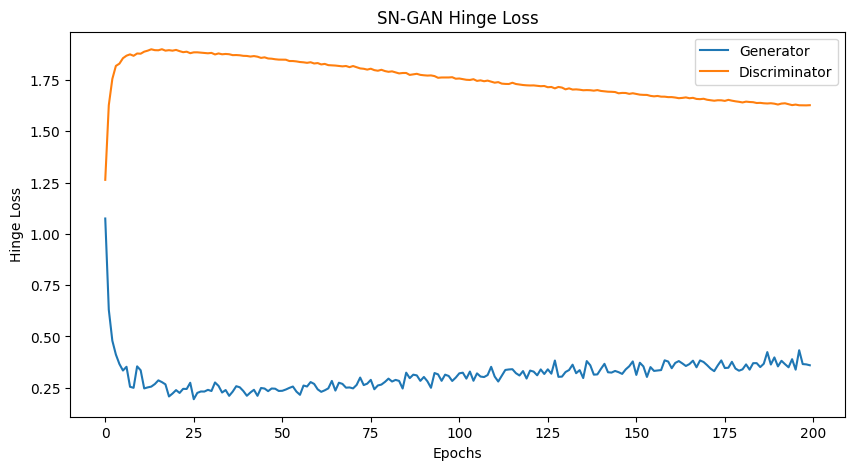

In [6]:
LEARNING_RATE = 2e-4
BATCH_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 100
NUM_EPOCHS = 200
DISC_ITERATIONS = 5
DEVICE = "cuda:4" if torch.cuda.is_available() else "cpu"

WEIGHT_PATH = "/scratch/s25090/sngan_outputs/weights/Experiment1"
PLOT_PATH = "/scratch/s25090/sngan_outputs/plots/Experiment1"
os.makedirs(WEIGHT_PATH, exist_ok=True)
os.makedirs(PLOT_PATH, exist_ok=True)

gan_model = SGANModel(z_dim=Z_DIM, channels_img=CHANNELS_IMG).to(DEVICE)
gan_model.train()

opt_gen = torch.optim.Adam(gan_model.generator.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_dis = torch.optim.Adam(gan_model.discriminator.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

train_dataset = CIFAR()
loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

print("Starting SN-GAN Training (Hinge Loss)...")
gen_loss_list = []
dis_loss_list = []

for epoch in range(NUM_EPOCHS):
    loop = tqdm(loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    
    epoch_gen_loss = 0
    epoch_dis_loss = 0
    batches_processed = 0
    
    for batch_idx, (real_img) in enumerate(loop):
        if isinstance(real_img, list) or isinstance(real_img, tuple):
            real_img = real_img[0]
            
        real_img = real_img.to(DEVICE)
        cur_batch_size = real_img.shape[0]
        batches_processed += 1

        opt_dis.zero_grad()
        z = torch.randn(cur_batch_size, Z_DIM).to(DEVICE)
        fake_img = gan_model.generator(z)
        d_real = gan_model.discriminator(real_img).reshape(-1)
        d_fake = gan_model.discriminator(fake_img.detach()).reshape(-1)
        loss_d_real = torch.mean(F.relu(1.0 - d_real))
        loss_d_fake = torch.mean(F.relu(1.0 + d_fake))
        
        loss_dis = loss_d_real + loss_d_fake
        
        loss_dis.backward()
        opt_dis.step()
        
        epoch_dis_loss += loss_dis.item()

        loss_gen_item = 0 
        
        if batch_idx % DISC_ITERATIONS == 0:
            opt_gen.zero_grad()
            
            gen_fake_logits = gan_model.discriminator(fake_img).reshape(-1)
            
            loss_gen = -torch.mean(gen_fake_logits)
            
            loss_gen.backward()
            opt_gen.step()
            
            loss_gen_item = loss_gen.item()
            epoch_gen_loss += loss_gen_item
            
            loop.set_postfix(
                d_loss=loss_dis.item(),
                g_loss=loss_gen.item()
            )

    avg_dis_loss = epoch_dis_loss / len(loader)
    avg_gen_loss = epoch_gen_loss / (len(loader) / DISC_ITERATIONS)
    
    gen_loss_list.append(avg_gen_loss)
    dis_loss_list.append(avg_dis_loss)

    print(f"Generator Loss: {avg_gen_loss:.4f} | Discriminator Loss: {avg_dis_loss:.4f}")

    if (epoch + 1) % 10 == 0:
        torch.save(gan_model.state_dict(), f"{WEIGHT_PATH}/sngan_epoch_{epoch+1}.pth")
        
        gan_model.eval()
        with torch.no_grad():
            test_z = torch.randn(8, Z_DIM).to(DEVICE)
            gan_images = gan_model.generator(test_z)
            
            comparison = torch.cat([real_img[:8], gan_images[:8]], dim=0)
            grid = make_grid(comparison.cpu(), nrow=8, padding=2, normalize=True)
            
            plt.figure(figsize=(12, 4))
            plt.imshow(grid.permute(1, 2, 0))
            plt.axis('off')
            plt.title(f'Top: Original | Bottom: Generated Image (Epoch {epoch+1})')
            plt.savefig(f"{PLOT_PATH}/Epoch-{epoch+1}.png")
            plt.close()
        gan_model.train()

plt.figure(figsize=(10, 5))
plt.title("SN-GAN Hinge Loss")
plt.plot(gen_loss_list, label="Generator")
plt.plot(dis_loss_list, label="Discriminator")
plt.xlabel("Epochs")
plt.ylabel("Hinge Loss")
plt.savefig(f"{PLOT_PATH}/Experiment1_loss.png")
plt.legend()
plt.show()